### File Explanation

**trainRNN_HBTRC_AttentionModel_dropout.ipynb:**
<br> This notebook is to load HBTRC examples from 'preprocessData_HBTRC.pickle', create an "Attention Network" and train the network with respect to a range of dropout rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model from fixed length sequences (function: **dynamicLSTM_Attention** in **trainRNN_network_utils.py**)
<br> 5) Create an attention mechanism based on a fully-connected layer of states and output, which is followed by a tanh layer to calculate scores. Then, calculate attention weights and context vector using softmax and dense layers 
<br> 6) Create a single output from a concatenation of context vectors of gene A and gene B
<br> 7) Pass the output through a **dense** layer and make prediction
<br> 8) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 9) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 10) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 11) Save them in "resultsAttentionDropout_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 5) **attention_matrixA**: Attention weights of gene A, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 6) **attention_matrixB**: Attention weights of gene B, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 7) **tst_prediction**: Test predictions, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [3]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [4]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropouts = [0.4, 0.5, 0.6, 0.7, 0.8]                # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [5]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
attention_matrixA = {}
attention_matrixB = {}
tst_prediction = {}

for dropout in dropouts:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM_Attention(rSnpRnaA_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_A = current_state_A[-1].h

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM_Attention(rSnpRnaB_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_B = current_state_B[-1].h

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    context_vectorA, attention_weightsA = attention(hidden_state_A, hidden_output_A, n_hidden)
    context_vectorB, attention_weightsB = attention(hidden_state_B, hidden_output_B, n_hidden)

    encoding = tf.concat((context_vectorA, context_vectorB), axis=1)

    # Dense Layer
    logits = tf.layers.dense(encoding,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.4),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.argmax(logits, 1)

    l2 = lambda_l2_reg * sum(
        tf.nn.l2_loss(tf_var)
            for tf_var in tf.trainable_variables()
            if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(prediction, tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Precision and recall
    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC               
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            

            if epoch_idx == (n_epoch-1):

                for i in range(rSnpRnaA_tst_nXNS.shape[0]):
                    rSnpRnaA_tst_nXNSA = np.expand_dims(rSnpRnaA_tst_nXNS[i], axis=0)
                    rSnpRnaB_tst_nXNSB = np.expand_dims(rSnpRnaB_tst_nXNS[i], axis=0)
                    rRelated_tst_nXC_ = np.expand_dims(rRelated_tst_nXC[i], axis=0)

                    pred, at_weightA, at_weightB = sess.run(
                        [prediction, attention_weightsA, attention_weightsB],
                        feed_dict = {
                                rSnpRnaA_pXNS: rSnpRnaA_tst_nXNSA,
                                rSnpRnaB_pXNS: rSnpRnaB_tst_nXNSB,
                                rRelated_pXC: rRelated_tst_nXC_
                                }) 

                    at_weightA = np.reshape(at_weightA, (-1, 1))
                    at_weightB = np.reshape(at_weightB, (-1, 1))

                    attention_matrixA[dropout] = at_weightA
                    attention_matrixB[dropout] = at_weightB                    
                    tst_prediction[dropout] = pred
    
        trainLosses[dropout] = train_losses
        testLosses[dropout] = test_losses
        trainAccuracy[dropout] = train_accuracies
        F1_scores[dropout] = test_f1_score
        print("Optimisation finished!")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1375489234924316: Accuracy = 0.4333333373069763
Performance on test set: : Loss = 1.1500471830368042: Accuracy = 0.6436781630457463

Data shuffled. Epoch: 

Performance on training data: Loss = 0.5634247660636902: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2634577751159668: Accuracy = 0.5124543874751611

Data shuffled. Epoch:  28
Performance on training data: Loss = 0.5305390357971191: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.8670077323913574: Accuracy = 0.5188571317299855

Data shuffled. Epoch:  29
Performance on training data: Loss = 0.5252467393875122: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.5677350759506226: Accuracy = 0.5229007758838163

Data shuffled. Epoch:  30
Performance on training data: Loss = 0.5284802317619324: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.3484827280044556: Accuracy = 0.5270988614258805

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.5279062986373901: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 1.6393933296203613: Accuracy = 0.5324941548591345

Data shuffled. Epoch:  32
Performance

Performance on training data: Loss = 0.4981778562068939: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 2.381173610687256: Accuracy = 0.5783338142988379

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.4615168869495392: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.2030656337738037: Accuracy = 0.579048305336212

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.4184589087963104: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.7963625192642212: Accuracy = 0.5788742846290019

Data shuffled. Epoch:  72
Performance on training data: Loss = 0.46648162603378296: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.46749210357666: Accuracy = 0.5786236628522688

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.4371525049209595: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 2.3281307220458984: Accuracy = 0.5792557051247933

Data shuffled. Epoch:  74
Performance on

Performance on training data: Loss = 0.40730875730514526: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.5779898166656494: Accuracy = 0.5832498950556083

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.420929878950119: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.635117530822754: Accuracy = 0.5833501491805878

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.3963993787765503: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.4302585124969482: Accuracy = 0.5839046990923339

Data shuffled. Epoch:  114
Performance on training data: Loss = 0.38987284898757935: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.9330735206604004: Accuracy = 0.5848978679338448

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.44735658168792725: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 2.5845484733581543: Accuracy = 0.5857855813611622

Data shuffled. Epoch:  116
Perfo

Performance on training data: Loss = 0.3717081844806671: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.8267431259155273: Accuracy = 0.6041175846767852

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.39030721783638: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.9620933532714844: Accuracy = 0.6047081757781115

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.35568177700042725: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 2.969320774078369: Accuracy = 0.6053411617792607

Data shuffled. Epoch:  156
Performance on training data: Loss = 0.37431371212005615: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.926046133041382: Accuracy = 0.6059630616640024

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.37784498929977417: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 3.1441471576690674: Accuracy = 0.6063534588855052

Data shuffled. Epoch:  158
Perform

Performance on training data: Loss = 0.34157171845436096: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 3.3800504207611084: Accuracy = 0.6177501844189939

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.36203494668006897: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.3492586612701416: Accuracy = 0.6179001206885696

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.3197115957736969: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 3.5235421657562256: Accuracy = 0.6180306835702852

Data shuffled. Epoch:  198
Performance on training data: Loss = 0.3790404498577118: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 3.518397808074951: Accuracy = 0.6181860014179816

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.288536936044693: Accuracy = 0.9133333563804626
Performance on test set: : Loss = 3.5726335048675537: Accuracy = 0.6184002435239728

Optimisation finished!
Data shuf

Performance on training data: Loss = 0.5114935040473938: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.5134329795837402: Accuracy = 0.6754373390069426

Data shuffled. Epoch:  38
Performance on training data: Loss = 0.5099542737007141: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.6271723508834839: Accuracy = 0.6754997883603816

Data shuffled. Epoch:  39
Performance on training data: Loss = 0.5025768280029297: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.9384100437164307: Accuracy = 0.675532170158538

Data shuffled. Epoch:  40
Performance on training data: Loss = 0.4664887487888336: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.5239254236221313: Accuracy = 0.67553188834799

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.4989672899246216: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.5952311754226685: Accuracy = 0.676907083809895

Data shuffled. Epoch:  42
Performance on t

Performance on training data: Loss = 0.44991591572761536: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.4326353073120117: Accuracy = 0.6454644947450353

Data shuffled. Epoch:  80
Performance on training data: Loss = 0.40277186036109924: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.0456416606903076: Accuracy = 0.6445815993362346

Data shuffled. Epoch:  81
Performance on training data: Loss = 0.3686796724796295: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.6884758472442627: Accuracy = 0.6447890041400108

Data shuffled. Epoch:  82
Performance on training data: Loss = 0.405781090259552: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.522512912750244: Accuracy = 0.6432486011699307

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.4126685857772827: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 2.46989107131958: Accuracy = 0.6423453423654486

Data shuffled. Epoch:  84
Performance on

Performance on training data: Loss = 0.37179139256477356: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.8228063583374023: Accuracy = 0.6190041645530402

Data shuffled. Epoch:  122
Performance on training data: Loss = 0.33895421028137207: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 2.5455570220947266: Accuracy = 0.6180171877983668

Data shuffled. Epoch:  123
Performance on training data: Loss = 0.3922390937805176: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 3.0551977157592773: Accuracy = 0.6174736053965693

Data shuffled. Epoch:  124
Performance on training data: Loss = 0.38303983211517334: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 3.144392251968384: Accuracy = 0.616480669066192

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.37276601791381836: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 3.33514142036438: Accuracy = 0.6151453523654423

Data shuffled. Epoch:  126
Perfo

Performance on training data: Loss = 0.3210092782974243: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 3.8049893379211426: Accuracy = 0.6002826498676561

Data shuffled. Epoch:  164
Performance on training data: Loss = 0.3535480499267578: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.495943784713745: Accuracy = 0.599663721046081

Data shuffled. Epoch:  165
Performance on training data: Loss = 0.3818883001804352: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 3.192755699157715: Accuracy = 0.5991639544840662

Data shuffled. Epoch:  166
Performance on training data: Loss = 0.31960102915763855: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 3.384045362472534: Accuracy = 0.5986176461919628

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.3318902850151062: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 3.175180435180664: Accuracy = 0.5980348403064548

Data shuffled. Epoch:  168
Performan

Performance on training data: Loss = 0.7877025604248047: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.469942569732666: Accuracy = 0.4639823032829744

Data shuffled. Epoch:  6
Performance on training data: Loss = 1.0872671604156494: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.5972638130187988: Accuracy = 0.43662430358798376

Data shuffled. Epoch:  7
Performance on training data: Loss = 1.0646843910217285: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1670583486557007: Accuracy = 0.4378731680839515

Data shuffled. Epoch:  8
Performance on training data: Loss = 1.0565266609191895: Accuracy = 0.5066666603088379
Performance on test set: : Loss = 1.1682740449905396: Accuracy = 0.4662095703439263

Data shuffled. Epoch:  9
Performance on training data: Loss = 0.9454669952392578: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.1422449350357056: Accuracy = 0.4494835972600722

Data shuffled. Epoch:  10
Performance on

Performance on training data: Loss = 0.5035605430603027: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.993377685546875: Accuracy = 0.5485121761214238

Data shuffled. Epoch:  48
Performance on training data: Loss = 0.4890609681606293: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.8269448280334473: Accuracy = 0.5505828294885026

Data shuffled. Epoch:  49
Performance on training data: Loss = 0.44498831033706665: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.077326536178589: Accuracy = 0.5514646973086247

Data shuffled. Epoch:  50
Performance on training data: Loss = 0.47651147842407227: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 2.04413104057312: Accuracy = 0.5530103284895823

Data shuffled. Epoch:  51
Performance on training data: Loss = 0.4212692975997925: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.9712340831756592: Accuracy = 0.5542790889449953

Data shuffled. Epoch:  52
Performance 

Performance on training data: Loss = 0.3964155912399292: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 2.6469123363494873: Accuracy = 0.5605219123872267

Data shuffled. Epoch:  90
Performance on training data: Loss = 0.365352064371109: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.5873332023620605: Accuracy = 0.5597476565533516

Data shuffled. Epoch:  91
Performance on training data: Loss = 0.4481755495071411: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 2.6123225688934326: Accuracy = 0.5595766385072698

Data shuffled. Epoch:  92
Performance on training data: Loss = 0.4291318356990814: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 2.727222442626953: Accuracy = 0.5590344005121812

Data shuffled. Epoch:  93
Performance on training data: Loss = 0.349998414516449: Accuracy = 0.846666693687439
Performance on test set: : Loss = 2.2927300930023193: Accuracy = 0.5589584396082686

Data shuffled. Epoch:  94
Performance on

Performance on training data: Loss = 0.40130650997161865: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.9748597145080566: Accuracy = 0.5668994825069597

Data shuffled. Epoch:  132
Performance on training data: Loss = 0.31914445757865906: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 2.908702850341797: Accuracy = 0.5677057129681112

Data shuffled. Epoch:  133
Performance on training data: Loss = 0.37568968534469604: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.4657769203186035: Accuracy = 0.5682022743971679

Data shuffled. Epoch:  134
Performance on training data: Loss = 0.3278880715370178: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 2.937110424041748: Accuracy = 0.5683732931478062

Data shuffled. Epoch:  135
Performance on training data: Loss = 0.30534660816192627: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 2.9840197563171387: Accuracy = 0.5684238262251561

Data shuffled. Epoch:  136
Per

Performance on training data: Loss = 0.307062566280365: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.278684377670288: Accuracy = 0.5801850380459876

Data shuffled. Epoch:  174
Performance on training data: Loss = 0.36255210638046265: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 2.9748666286468506: Accuracy = 0.5802903219695821

Data shuffled. Epoch:  175
Performance on training data: Loss = 0.4234374761581421: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 3.06591796875: Accuracy = 0.5808504702305626

Data shuffled. Epoch:  176
Performance on training data: Loss = 0.3543025255203247: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 3.8983805179595947: Accuracy = 0.580895917253543

Data shuffled. Epoch:  177
Performance on training data: Loss = 0.3505418002605438: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 3.4678683280944824: Accuracy = 0.5812787294552252

Data shuffled. Epoch:  178
Performance 

Performance on training data: Loss = 0.5367133617401123: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.698639988899231: Accuracy = 0.46248922167939654

Data shuffled. Epoch:  16
Performance on training data: Loss = 0.5370010733604431: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.399477243423462: Accuracy = 0.4726294224531032

Data shuffled. Epoch:  17
Performance on training data: Loss = 0.5495967268943787: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.6980046033859253: Accuracy = 0.4750031862071618

Data shuffled. Epoch:  18
Performance on training data: Loss = 0.6166722178459167: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.5570886135101318: Accuracy = 0.478543924898806

Data shuffled. Epoch:  19
Performance on training data: Loss = 0.5384612679481506: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.6781978607177734: Accuracy = 0.4836571421976787

Data shuffled. Epoch:  20
Performance 

Performance on training data: Loss = 0.468209832906723: Accuracy = 0.746666669845581
Performance on test set: : Loss = 3.2433269023895264: Accuracy = 0.507429831237192

Data shuffled. Epoch:  58
Performance on training data: Loss = 0.4404065012931824: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 3.044050693511963: Accuracy = 0.5067285453702209

Data shuffled. Epoch:  59
Performance on training data: Loss = 0.4702926576137543: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 2.326354503631592: Accuracy = 0.5057086139882114

Data shuffled. Epoch:  60
Performance on training data: Loss = 0.4217087924480438: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.8203961849212646: Accuracy = 0.5039729934680195

Data shuffled. Epoch:  61
Performance on training data: Loss = 0.45297476649284363: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.527419090270996: Accuracy = 0.5037998853643052

Data shuffled. Epoch:  62
Performance on t

Performance on training data: Loss = 0.4172610938549042: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.8080267906188965: Accuracy = 0.514307914722834

Data shuffled. Epoch:  100
Performance on training data: Loss = 0.4679044187068939: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.662155866622925: Accuracy = 0.514595580031257

Data shuffled. Epoch:  101
Performance on training data: Loss = 0.429576575756073: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.518099546432495: Accuracy = 0.5161492629038066

Data shuffled. Epoch:  102
Performance on training data: Loss = 0.431307315826416: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 3.139387369155884: Accuracy = 0.5161176084112344

Data shuffled. Epoch:  103
Performance on training data: Loss = 0.42278361320495605: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.577599287033081: Accuracy = 0.5171370931521692

Data shuffled. Epoch:  104
Performance 

Performance on training data: Loss = 0.3699284493923187: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.978797674179077: Accuracy = 0.5347601505878131

Data shuffled. Epoch:  142
Performance on training data: Loss = 0.35705697536468506: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.650428295135498: Accuracy = 0.5347882140535096

Data shuffled. Epoch:  143
Performance on training data: Loss = 0.41277581453323364: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.4838368892669678: Accuracy = 0.5354567726272408

Data shuffled. Epoch:  144
Performance on training data: Loss = 0.4094064235687256: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.040377140045166: Accuracy = 0.5360266328564371

Data shuffled. Epoch:  145
Performance on training data: Loss = 0.47701722383499146: Accuracy = 0.746666669845581
Performance on test set: : Loss = 2.947176218032837: Accuracy = 0.5360991032181802

Data shuffled. Epoch:  146
Perform

Performance on training data: Loss = 0.36232200264930725: Accuracy = 0.8933333158493042
Performance on test set: : Loss = 2.5911686420440674: Accuracy = 0.5448382653986407

Data shuffled. Epoch:  184
Performance on training data: Loss = 0.3765561282634735: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.1440229415893555: Accuracy = 0.544890155650886

Data shuffled. Epoch:  185
Performance on training data: Loss = 0.3644564747810364: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.6613354682922363: Accuracy = 0.5450796547323534

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.34425848722457886: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.007601499557495: Accuracy = 0.5456266788853212

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.3362971246242523: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 2.6543664932250977: Accuracy = 0.5455911253391101

Data shuffled. Epoch:  188
Perfo

Performance on training data: Loss = 0.5466911196708679: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.8497751951217651: Accuracy = 0.6721759032866961

Data shuffled. Epoch:  26
Performance on training data: Loss = 0.5355507135391235: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.1650753021240234: Accuracy = 0.6723462046024442

Data shuffled. Epoch:  27
Performance on training data: Loss = 0.5349249839782715: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.2941792011260986: Accuracy = 0.6743290300584335

Data shuffled. Epoch:  28
Performance on training data: Loss = 0.5210047364234924: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.5544650554656982: Accuracy = 0.6742127375581661

Data shuffled. Epoch:  29
Performance on training data: Loss = 0.5223917365074158: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.6382544040679932: Accuracy = 0.6750827364805178

Data shuffled. Epoch:  30
Performance 

Performance on training data: Loss = 0.45638900995254517: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.9758070707321167: Accuracy = 0.6328207299729787

Data shuffled. Epoch:  68
Performance on training data: Loss = 0.47272536158561707: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.0114290714263916: Accuracy = 0.6329056059463741

Data shuffled. Epoch:  69
Performance on training data: Loss = 0.4132501184940338: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 3.7026076316833496: Accuracy = 0.6317072234188071

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.4271678030490875: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.392810821533203: Accuracy = 0.6306331766925168

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.4249647259712219: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.3841047286987305: Accuracy = 0.6293644355865733

Data shuffled. Epoch:  72
Performan

Performance on training data: Loss = 0.42932674288749695: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 2.9211859703063965: Accuracy = 0.60057772670456

Data shuffled. Epoch:  110
Performance on training data: Loss = 0.41674646735191345: Accuracy = 0.746666669845581
Performance on test set: : Loss = 2.285639524459839: Accuracy = 0.60013588900352

Data shuffled. Epoch:  111
Performance on training data: Loss = 0.39842379093170166: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 3.311455011367798: Accuracy = 0.6001454625563811

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.44872498512268066: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.776102066040039: Accuracy = 0.5994445389909991

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.3618215024471283: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.954038143157959: Accuracy = 0.5992133030405715

Data shuffled. Epoch:  114
Performanc

Performance on training data: Loss = 0.41530469059944153: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 3.34248423576355: Accuracy = 0.5965821663575879

Data shuffled. Epoch:  152
Performance on training data: Loss = 0.3916817307472229: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 3.298912525177002: Accuracy = 0.5967759238933867

Data shuffled. Epoch:  153
Performance on training data: Loss = 0.3263241946697235: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 3.1404740810394287: Accuracy = 0.597039041957416

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.36564767360687256: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 3.35819673538208: Accuracy = 0.5968997758625006

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.42741841077804565: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 3.301903009414673: Accuracy = 0.5969852498730399

Data shuffled. Epoch:  156
Performan

Performance on training data: Loss = 0.3299492597579956: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.509446620941162: Accuracy = 0.6012059209939817

Data shuffled. Epoch:  194
Performance on training data: Loss = 0.3813638389110565: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 3.4549145698547363: Accuracy = 0.6009105225883493

Data shuffled. Epoch:  195
Performance on training data: Loss = 0.2997725009918213: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 3.3590760231018066: Accuracy = 0.601162412135993

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.37630903720855713: Accuracy = 0.800000011920929
Performance on test set: : Loss = 3.2964460849761963: Accuracy = 0.6009114803520916

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.3218667507171631: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 3.6977949142456055: Accuracy = 0.6012226974035209

Data shuffled. Epoch:  198
Perform

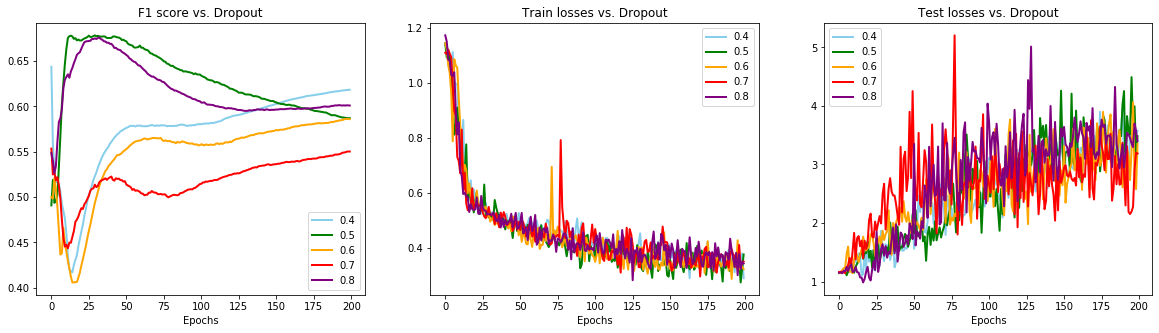

In [6]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Dropout")

In [7]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsAttentionDropout_HBTRC.pickle', 'wb') as f:
    pickle.dump( rSnpRnaA_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpRnaB_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixA, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixB, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( tst_prediction, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
